# Workbook on Biomedical Imaging extraction
This workbook will have you practice some of the methods that we introduced in the demonstration notebook. For each step, you will find instructions for what to do followed by an empty code cell to enter your work. Don't forget that you will need to import the appropriate packages for this work.

The demonstration notebook showed you how to do a lot of these tasks within Python. However, if you would like to try out different command lines or include screenshots from your viewer, then we can show you how to include those into your answer.

In [ ]:
# Put your import statements here. 

## Step 1 - Load an MRI image
Please download the ADNI data from the Teams Channel. In the demonstration notebook we used subject `011-S-4906`. For this team workbook, please use subject `014-S-4263`. There are other subjects if you want to explore these methods on more data. Load in the raw image data and obtain the following information about the image.
* The number of slices
* The distance and time units used in this image
* The dimensions of each voxel
* The minimum and maximum intensity range
* The intensity value at the 50th column, 75th row, and 80th slice - **remember what number Python starts counting with.
* The Voxel-to-World mapping

In [6]:
# Your answer to Step 1
# Below put your code that will load up the image and prodcued the requested information
import os
import nibabel as nb
import numpy as np
from niwidgets import NiftiWidget
import pandas as pd
import ants

data_root="/mnt/c/Users/adamr/Documents/GitHub/TeamCoders_Event_Based_Model/bids"
t1_img_name = os.path.join(data_root,"sub-014-S-4263","anat",
                            "sub-014-S-4263_desc-t1.nii.gz")
#This is the command that loads the image in
t1_img = nb.load(t1_img_name)
t1_img_data = t1_img.get_fdata()



print(f"Dimensons {t1_img.shape}")
print(f"Distance and Time Units: {t1_img.header.get_xyzt_units()}")
print(f"Voxel spacing (in mm): {t1_img.header.get_zooms()}")

test_voxel = (49,74,79)
print(f"Intensity at voxel {t1_img_data[test_voxel]}")
img_min = t1_img_data.min()
img_max = t1_img_data.max()
print(f"Minimum: {img_min}")
print(f"Maximum: {img_max}")

print(t1_img.affine)

Intensity at voxel 182.0
Dimensons (176, 240, 256)
Distance and Time Units: ('mm', 'sec')
Voxel spacing (in mm): (1.1999999, 1.0546875, 1.0546875)
Minimum: 0.0
Maximum: 1000.0
[[   1.20000458    0.            0.         -105.00079346]
 [   0.            1.0546875     0.          -86.45697021]
 [   0.            0.            1.0546875  -157.8097229 ]
 [   0.            0.            0.            1.        ]]


## Step 2 - Bias Correction
Perform bias correction on the brain image and plot the corrected image and the difference between the original and corrected image. Try the N4 algorithm as well as the N3 and let me know what differences (if any) that you find

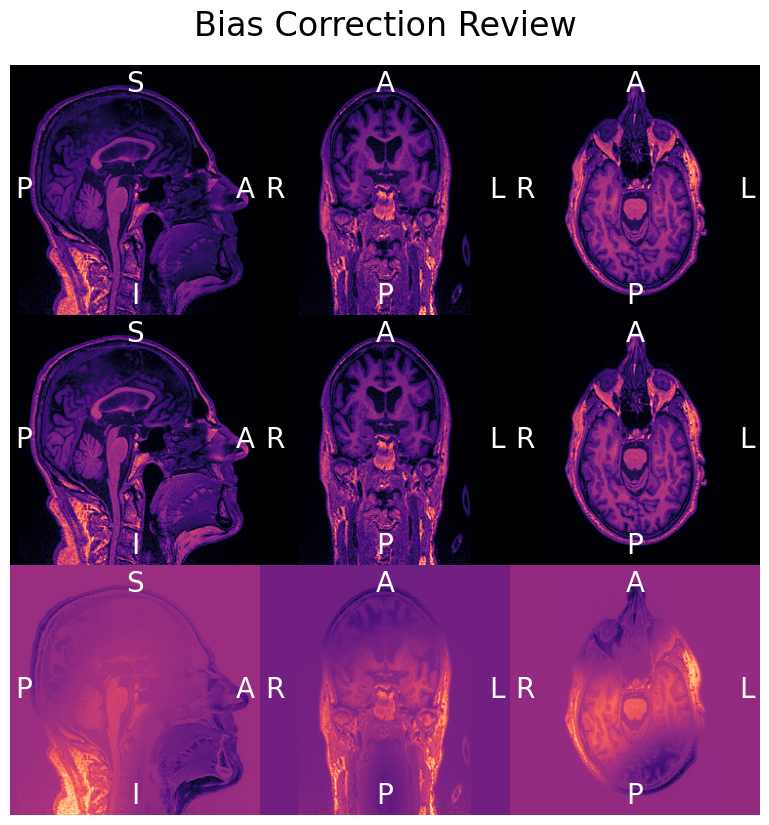

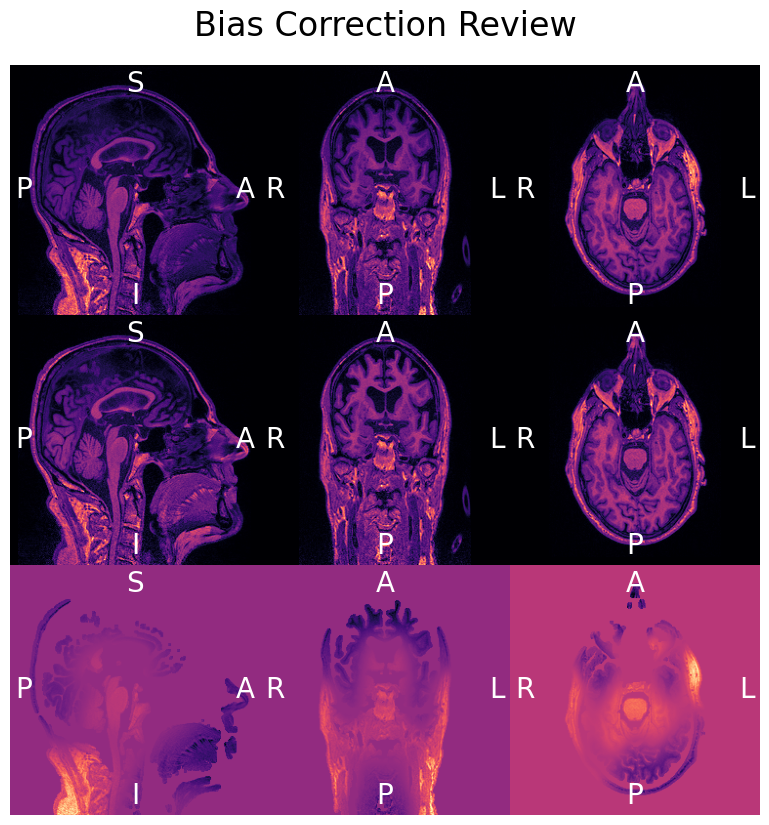

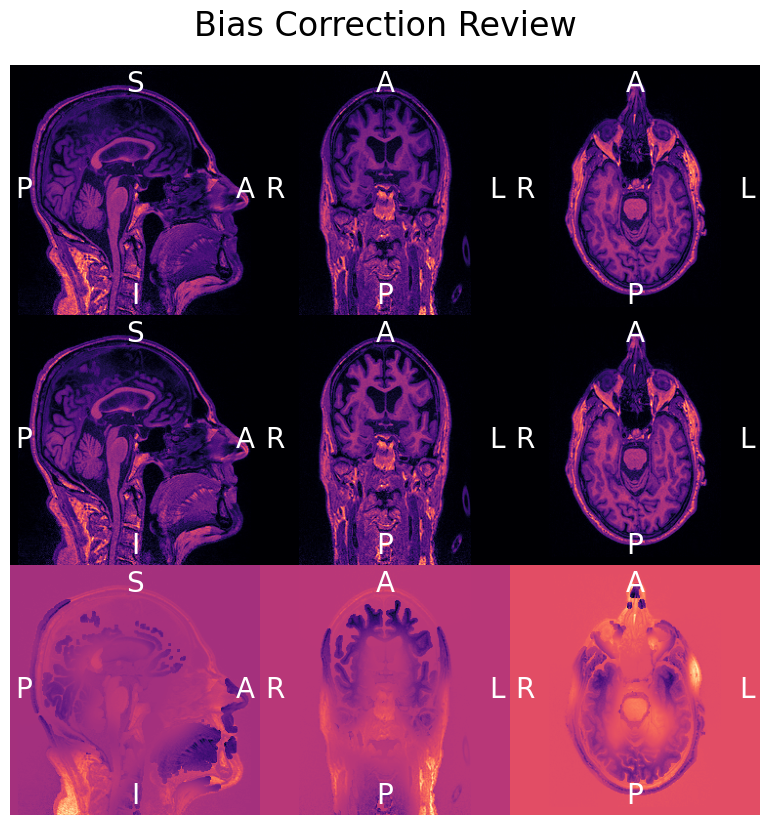

In [10]:
# Your answers to Step 2
# Load in the image
t1_img = ants.image_read(t1_img_name)

#Peform the N3 bias correcction
t1_n3 = ants.n3_bias_field_correction(t1_img)
t1_n4 = ants.n4_bias_field_correction(t1_img)

t1_n3_diff = t1_img - t1_n3
t1_n4_diff = t1_img - t1_n4
n3_n4_diff = t1_n3 - t1_n4
ants.plot_ortho_stack(images = [t1_img,t1_n3,t1_n3_diff],
                      title="Bias Correction Review",
                     cmap = "magma")

ants.plot_ortho_stack(images = [t1_img,t1_n4,t1_n4_diff],
                      title="Bias Correction Review",
                     cmap = "magma")

ants.plot_ortho_stack(images = [t1_n3, t1_n4, n3_n4_diff],
                      title="Bias Correction Review",
                     cmap = "magma")

# N3 bias correction provides stronger bias correction in below the ventricles. N4 bias correction ignores
# more of the bias field associated with the superior dura and skull. Both show that the bias field was 
# oriented on a diagonal from right-posterior to left-anterior. 

## Step 3 - Brain extraction
Produce a skull-stripped image from the bias corrected image. Make sure to do additional cleaning if you think it is necessary. What is the volume of the resulting mask?

 bad det -1 v -1 u 1
 bad det -1 v -1 u 1 new 1


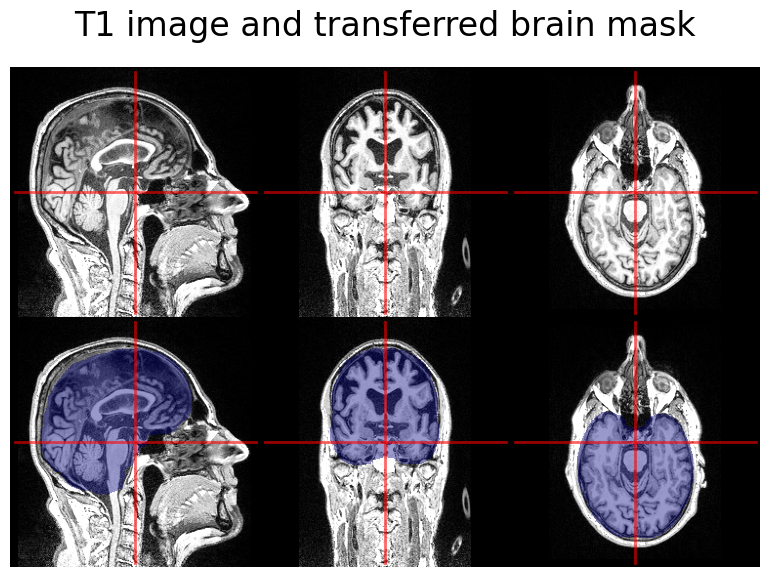

In [13]:
# Your answer to Step 3

atlasdir = os.path.join(data_root,"atlas")
# Load MNI image
mni_img_file = os.path.join(atlasdir,"MNI152_T1_1mm.nii.gz")
mni_img = ants.image_read(mni_img_file)
# Load MNI mask
mni_mask_file = os.path.join(atlasdir,"MNI152_T1_1mm_brain_mask_dil.nii.gz")
mni_mask = ants.image_read(mni_mask_file)


# Find initial guess
init_tx_file = ants.affine_initializer(fixed_image = mni_img, moving_image = t1_n4, mask = mni_mask)
init_tx = ants.read_transform(init_tx_file)
# Transform T1 with initial guess
t1_mni_init = ants.apply_transforms(fixed = mni_img, moving = t1_n4,transformlist=init_tx_file)

affine = ants.registration(fixed = mni_img, moving = t1_n4,
                           mask = mni_mask,
                           type_of_transform = "Affine", 
                           initial_transform = init_tx_file)

t1_mask = ants.apply_transforms(fixed = t1_n4, moving = mni_mask, interpolator="nearestNeighbor",
                                transformlist=affine['fwdtransforms'],whichtoinvert=[True])
ants.plot_ortho_double(image=t1_n4, image2=t1_n4, scale=True, scale2=True, overlay=t1_mask, overlay2=t1_mask,
                       overlay_alpha=0.0, overlay_alpha2=0.4,title="T1 image and transferred brain mask",title_dy=0.25)

# Some dura remains.

# Mask cleanup

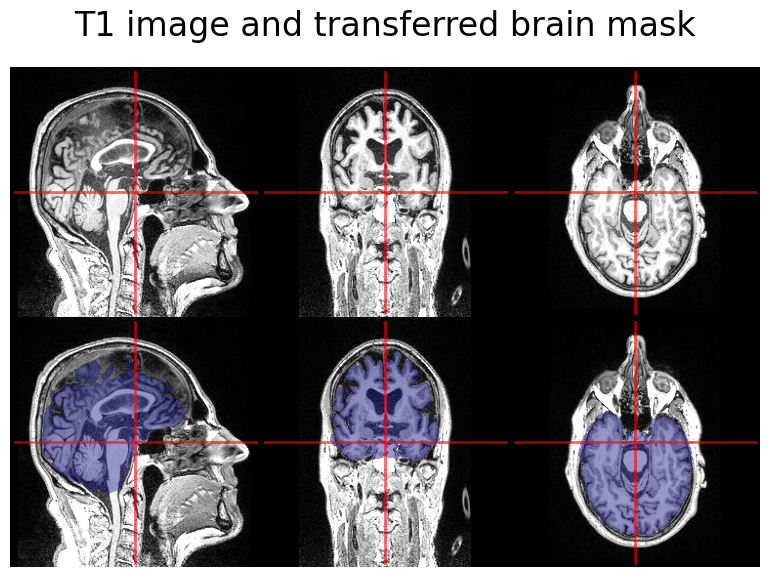

In [36]:
# The utility get_mask can clean up the additional bits outside the brain
t1_brain = ants.mask_image(t1_n4,t1_mask)
t1_mask_cleaned = ants.get_mask(t1_brain,cleanup=3)
t1_brain_cleaned = ants.mask_image(t1_n4,t1_mask_cleaned)

ants.plot_ortho_double(image=t1_n4, image2=t1_n3, scale=True, scale2=True, overlay=t1_mask_cleaned, overlay2=t1_mask_cleaned,
                       overlay_alpha=0.0, overlay_alpha2=0.4,title="T1 image and transferred brain mask",title_dy=0.25)

In [27]:
tissue_stats = ants.label_stats(t1_n4,t1_mask_cleaned)
mask_vol = tissue_stats[tissue_stats.LabelValue == 1.0].Volume
print(f"Mask volume: {mask_vol}")

Mask volume: 0    1574964.25
Name: Volume, dtype: float64


## Step 4 - Tissue segmentation
Perform tissue segmentation on the image. Is the GM volume in this subject more or less than the subject `011-S-4906`? Is it a greater or less percentage of the overall brain?

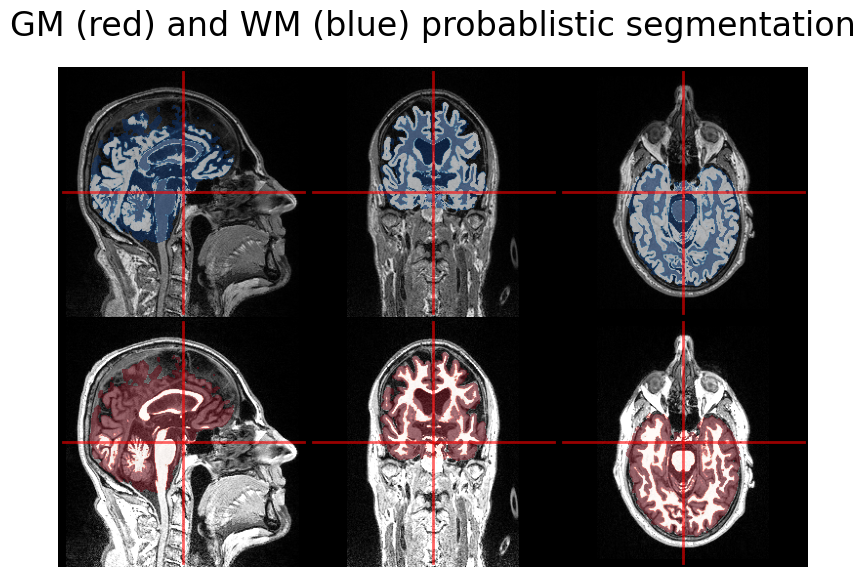

   LabelValue        Mean         Min         Max      Variance      Count  \
3         0.0   58.451815    0.000000  851.000000  10103.372822  9633549.0   
0         1.0   75.972021    0.000000  180.000000    948.894461   293161.0   
1         2.0  191.911119   90.069016  569.660034    949.384916   528525.0   
2         3.0  279.514631  194.422821  646.526917    629.992051   358205.0   

         Volume          Mass         x          y         z    t  
3  1.285923e+07  0.000000e+00  0.000000   0.000000  0.000000  0.0  
0  3.913227e+05  2.227203e+07 -1.488751 -12.132514  0.469899  0.0  
1  7.054956e+05  1.014298e+08  0.910585  -9.112221 -3.325929  0.0  
2  4.781459e+05  1.001235e+08  0.149041 -12.087915  5.080740  0.0  


In [28]:
# Your answer to Step 4
tissue_seg = ants.atropos(a=t1_n4,x=t1_mask_cleaned,m="[0.3,1x1x1]", i='Kmeans[3]')

ants.plot_ortho_double(image = t1_n4,image2=t1_n4,
                       overlay=tissue_seg['probabilityimages'][1], overlay_alpha=0.5, overlay_cmap='Blues_r',
                       overlay2=tissue_seg['probabilityimages'][2], overlay_alpha2=0.5,overlay_cmap2='Reds_r',
                       title="GM (red) and WM (blue) probablistic segmentation",title_dy=0.25)

tissue_stats = ants.label_stats(t1_n4,tissue_seg['segmentation'])
print(tissue_stats)

## Step 5 - Brain parcellation
One of you should run FreeSurfer on this subject. You should also transfer the AAL labels to this subject. Tell me what the volumes of the left and right precuneus are for both methods.

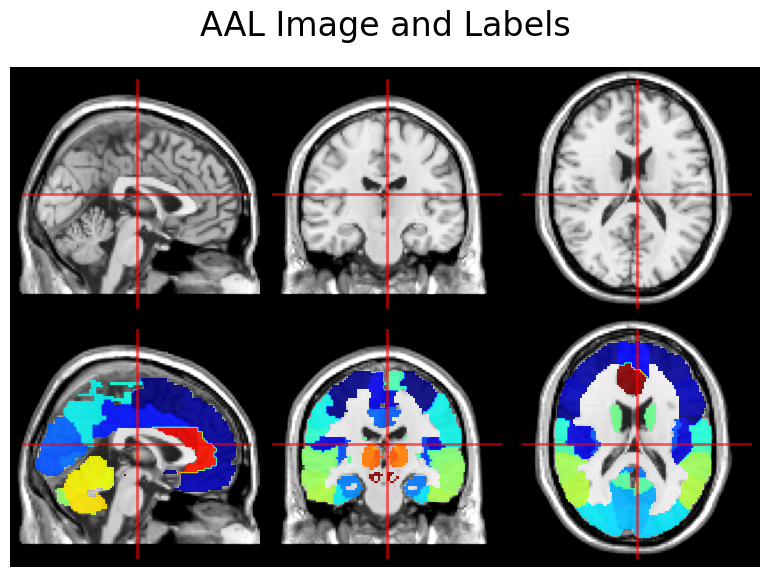

In [31]:
# Your answer to Step 5
# Determine template, rigid + SYN and then transfer labels over. 
aal_template_file = os.path.join(atlasdir,"AAL3v1_1mm.nii.gz")
aal_template = ants.image_read(aal_template_file).astype("uint32")
aal_img_file = os.path.join(atlasdir,"single_subj_T1.nii")
aal_img = ants.image_read(aal_img_file)
ants.plot_ortho_double(image=aal_img,image2=aal_img, scale=True,scale2=True,overlay=aal_template,overlay2=aal_template,
                      overlay_alpha=0.0,title="AAL Image and Labels",title_dy=0.25)

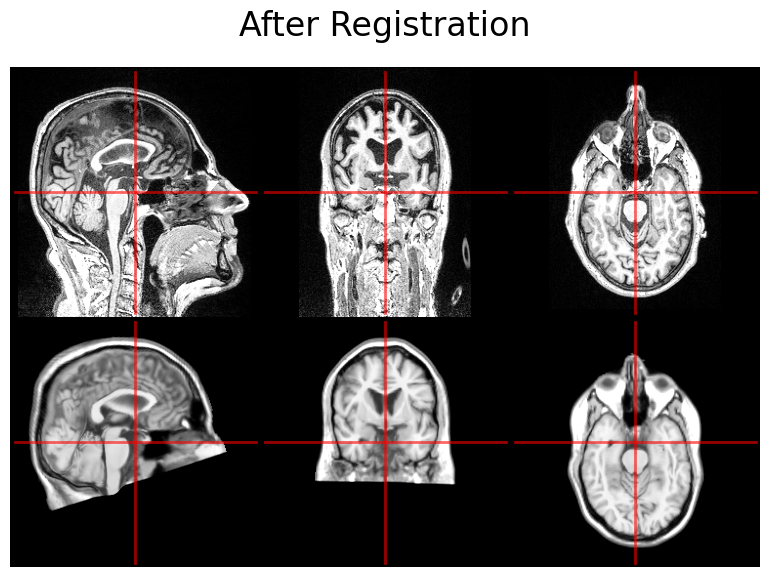

In [48]:
# Do an affine initialisation
t1_mask_dil = ants.iMath(t1_mask_cleaned,'MD',2)
aal_affine_init_file = ants.affine_initializer(fixed_image = t1_n4,moving_image = aal_img)

# Perform deformable registration using SyN and MI
# Affine initializer was removed because it generated poorer performing registration.
syn_aal = ants.registration(fixed=t1_n4,
                            moving=aal_img,
                            mask=t1_mask_dil,
                            type_of_transform="SyN")

ants.plot_ortho_double(image=t1_n4, image2=syn_aal['warpedmovout'], scale=True,scale2=True,
                       title="After Registration",title_dy=0.25)


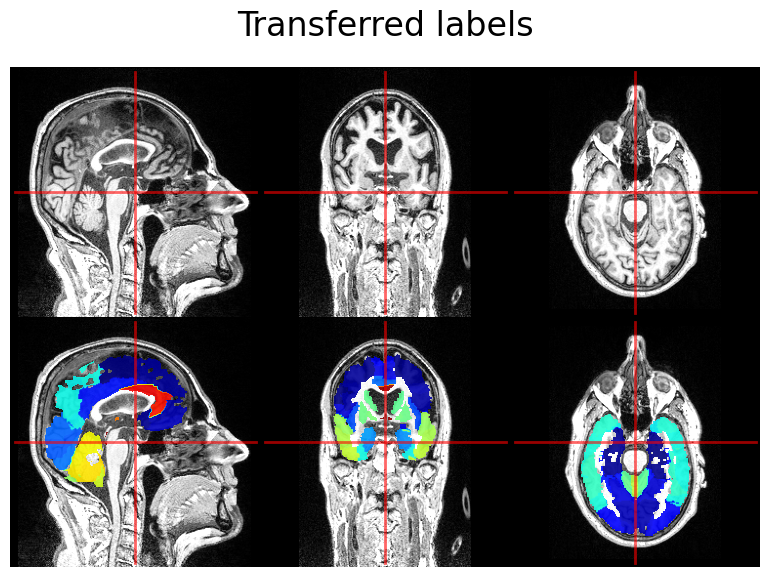

In [49]:

# Transfer anatomical labels from AAL to our image
t1_aal_label = ants.apply_transforms(fixed = t1_n4, moving = aal_template,
                                     transformlist=syn_aal['fwdtransforms'],interpolator="genericLabel")
ants.plot_ortho_double(image=t1_n4,image2=t1_n4,overlay=t1_aal_label,overlay2=t1_aal_label,
                       scale=True,scale2=True,
                      overlay_alpha=0.0,title="Transferred labels",title_dy=0.25)

## Step 6 - PET SUVR measurements
Finally, register the PET data with the MRI and give SUVR precuneus measures from both parcellations above using the cerebellum region as the reference. Is this person have higher or lower uptake than subject `011-S-4906`? What would the SUVR be if the reference region was the pons?

In [ ]:
# Your answer to Step 6
# Creating a brain mask and extracting volumes out